In [1]:
import warnings
warnings.filterwarnings("ignore")

SEED = 1
N_IMG = 1

In [2]:
import random

import diffusers
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import torch

from src.diffusion_models import SDXLEditingPipeline
from src.llms import spot_objects
from src.detectors import OWLViTv2Detector

device = torch.device("cuda:1")
device1 = torch.device("cuda:2")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
base = SDXLEditingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device1)
use_ddpm = True
if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Using DDPM as scheduler.


In [4]:
prompts = [
    "Two people enjoying hot dogs and soda pop.",
    "Two people walking under an umbrella on a street near some benches and a motorcycle.",
    "a woman in a blue top carrying two surfboards across a street",
    "A woman surfer riding on a crashing wave",
    "A man walking along a beach holding a surfboard"
]

In [5]:
generator = torch.Generator(device=device1).manual_seed(SEED)
out = base(prompt=[prompts[0]]*N_IMG, num_inference_steps=300, generator=generator, latents=None)

100%|██████████| 300/300 [00:37<00:00,  7.98it/s]


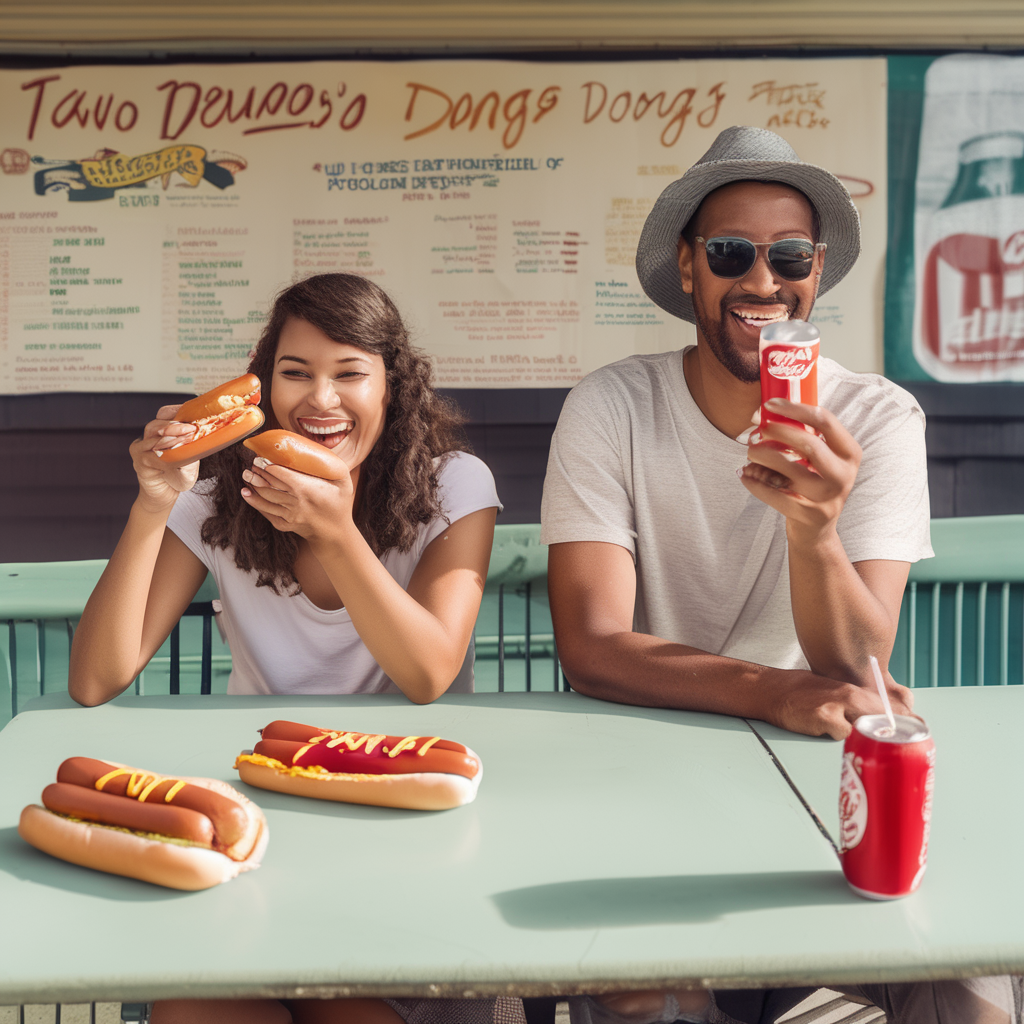

In [6]:
out.images[0]

In [18]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type (e.g., "people", "monkey"), the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes (e.g., "green", "happy") for corresponding object. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.
"""

In [19]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
model.eval()
model.to("cuda:0")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]


LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): Q

In [22]:
responses = []
for prompt in prompts:
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"
    out = base(prompt=[prompt]*N_IMG, num_inference_steps=300, generator=generator, latents=None)

    inputs = processor(query, out.images[0], return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:37<00:00,  8.02it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:37<00:00,  7.94it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:37<00:00,  7.90it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:37<00:00,  7.90it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:38<00:00,  7.89it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [23]:
for response in responses:
    print(response)
    print("--------")

INST] Based on the image provided, here is the list of tuples as per your request:

[('people', ['man', 'woman']), ('man', ['eating', 'drinking']), ('woman', ['eating', 'drinking'])]

Please note that the image shows two individuals, a man and a woman, who are both eating and drinking. The man is holding a hot dog and a red cup, while the woman is holding a hot dog and a white cup. They are both seated on a bench, enjoying their meal and beverages. </s>
--------
INST] Based on the image provided, here is the list of tuples as per your request:

[('people', ['walking', 'under umbrella']), ('motorcycle', ['parked'])] </s>
--------
INST] Based on the image provided, here is the list of tuples as requested:

[('people', ['woman in blue top']), ('surfboards', ['blue surfboard', 'white surfboard'])] </s>
--------
INST] Based on the image provided, here is the list of tuples as per your request:

[('people', ['surfer'])]

Please note that the image only shows one person, a woman surfer, and s